# Using pretrained model (VGG16) for pneumonia detection

Load the model and define paths to data

In [7]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGESHAPE = [224, 224, 3] 
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

for each_layer in vgg_model.layers:
    each_layer.trainable = False

training_data = 'chest_xray/train'
testing_data = 'chest_xray/test'


classes = glob(f'{training_data}/*')

Add flattening and prediction layers and create the model

In [8]:
# Add flattening and prediction layers
flatten_layer = Flatten()(vgg_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)

# Create final model
final_model = Model(inputs=vgg_model.input, outputs=prediction)
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Compile the model and load the data

In [9]:
# Compile the model with Adam optimizer and categorical crossentropy loss
final_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Prepare the data generators for training and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the directories
print("Training set:")
training_set = train_datagen.flow_from_directory(
    training_data,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)


print("Test set:")
test_set = test_datagen.flow_from_directory(
    testing_data,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

# Fit the model
fitted_model = final_model.fit(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Training set:
Found 661 images belonging to 2 classes.
Test set:
Found 440 images belonging to 2 classes.
Epoch 1/5
166/166 [==============================] - 284s 2s/step - loss: 0.3827 - accuracy: 0.8865 - val_loss: 0.9060 - val_accuracy: 0.7750
Epoch 2/5
166/166 [==============================] - 261s 2s/step - loss: 0.1653 - accuracy: 0.9470 - val_loss: 0.8259 - val_accuracy: 0.8227
Epoch 3/5
166/166 [==============================] - 245s 1s/step - loss: 0.2792 - accuracy: 0.9289 - val_loss: 0.6539 - val_accuracy: 0.8545
Epoch 4/5
166/166 [==============================] - 240s 1s/step - loss: 0.1537 - accuracy: 0.9637 - val_loss: 0.5988 - val_accuracy: 0.8455
Epoch 5/5
166/166 [==============================] - 232s 1s/step - loss: 0.1400 - accuracy: 0.9637 - val_loss: 0.7452 - val_accuracy: 0.8318


Plot the results and save the model

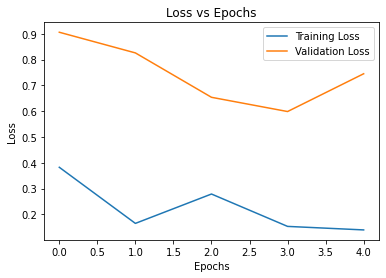

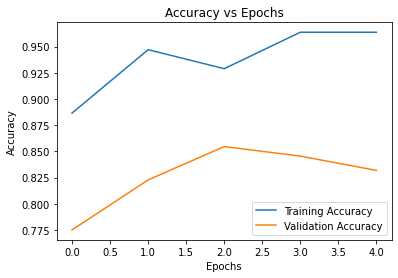

In [10]:
# Plot training and validation loss
plt.plot(fitted_model.history['loss'], label='Training Loss')
plt.plot(fitted_model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(fitted_model.history['accuracy'], label='Training Accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Save the model
final_model.save('my_model.h5')

Test the model

In [12]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = load_model('my_model.h5')

img_path = 'chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg'
img = image.load_img(img_path, target_size=(224, 224)) 

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_data = preprocess_input(img_array)

prediction = model.predict(img_data)

if prediction[0][0] > prediction[0][1]:
    print('Prediction: Person is safe.')
else:
    print('Prediction: Person is affected.')

print(f'Raw Predictions: {prediction}')

Prediction: Person is affected.
Raw Predictions: [[0. 1.]]
